# Assignment 4 - Spark basics

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("ex4") \
       .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
       .getOrCreate()

spark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
45 packages can be upgraded. Run 'apt list --upgradable' to see them.
tar: spark-3.2.1-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recov

In [ ]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, row_number, mean, max, round, monotonically_increasing_id
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import Row
from pyspark.sql.window import Window
from pyspark import SparkContext

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nba_stats.csv to nba_stats (1).csv


In [ ]:
nba_stats = spark.read.csv(path='nba_stats.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True,
                        inferSchema=True)
nba_stats.show(n=5, truncate=False)

+---+--------------+----+-----+-----------+---+---+---+---+---+----+---+----+-----+---+---+-----+---+----+-----+-----+---+---+-----+---+---+---+---+---+---+---+---+----+------+-------+-------+-----+----------------------+---+---+-----+---+-----+-----+----+
|_c0|Player        |Ht  |Wt   |Colleges   |Pos|Age|Tm |G  |GS |MP  |FG |FGA |FG%  |3P |3PA|3P%  |2P |2PA |2P%  |eFG% |FT |FTA|FT%  |ORB|DRB|TRB|AST|STL|BLK|TOV|PF |PTS |Year  |Pts Won|Pts Max|Share|Team                  |W  |L  |W/L% |GB |PS/G |PA/G |SRS |
+---+--------------+----+-----+-----------+---+---+---+---+---+----+---+----+-----+---+---+-----+---+----+-----+-----+---+---+-----+---+---+---+---+---+---+---+---+----+------+-------+-------+-----+----------------------+---+---+-----+---+-----+-----+----+
|0  |Alaa Abdelnaby|6-10|240.0|Duke       |PF |22 |POR|43 |0  |6.7 |1.3|2.7 |0.474|0.0|0.0|0.0  |1.3|2.7 |0.474|0.474|0.6|1.0|0.568|0.6|1.4|2.1|0.3|0.1|0.3|0.5|0.9|3.1 |1991.0|0.0    |0.0    |0.0  |Portland Trail Blazers|63 |19 |

### Best scorers

In [ ]:
nba_stats.orderBy('PTS', ascending=False).limit(10).toPandas()[['Year', 'Player', 'Age', 'PTS']]

,Year,Player,Age,PTS
0,1987.0,Michael Jordan,23,37.1
1,2019.0,James Harden,29,36.1
2,2006.0,Kobe Bryant,27,35.4
3,1988.0,Michael Jordan,24,35.0
4,2020.0,James Harden,30,34.3
5,1990.0,Michael Jordan,26,33.6
6,1980.0,George Gervin,27,33.1
7,2006.0,Allen Iverson,30,33.0
8,1985.0,Bernard King,28,32.9
9,1993.0,Michael Jordan,29,32.6


### Average number of 3 point attempts for each season in a time limit of 48 minutes

In [ ]:
sum_of_attempts = nba_stats.groupBy('Year').agg({'MP' : 'sum', '3PA' : 'sum'}).select(F.col('Year'), (48*F.col('sum(3PA)')/F.col('sum(MP)')).alias('P3A_48min')).orderBy(F.col('Year'))

Text(0.5, 1.0, 'Average number of 3 point attempts for each season (per 48 minutes)')

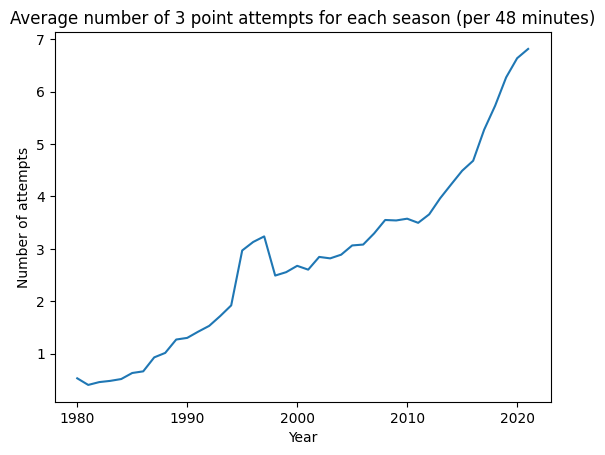

In [ ]:
plot_atempts = sum_of_attempts.toPandas()
plt.plot(plot_atempts.Year, plot_atempts.P3A_48min)
plt.xlabel('Year')
plt.ylabel('Number of attempts')
plt.title('Average number of 3 point attempts for each season (per 48 minutes)')

### predict the average number of 3 point attempts for the next 5 years.

In [ ]:
assembler = VectorAssembler(inputCols=['Year'], outputCol = 'features')
training = assembler.transform(sum_of_attempts)\
.withColumn('Year',sum_of_attempts.Year)\
.withColumn('label',sum_of_attempts.P3A_48min)
training.toPandas().tail()

,Year,P3A_48min,features,label
37,2017.0,5.273988,[2017.0],5.273988
38,2018.0,5.732723,[2018.0],5.732723
39,2019.0,6.273113,[2019.0],6.273113
40,2020.0,6.638921,[2020.0],6.638921
41,2021.0,6.816210,[2021.0],6.816210


In [ ]:
training_df = training.withColumn("Year", col("Year").cast("integer"))
training_df.show()

+----+-------------------+--------+-------------------+
|Year|          P3A_48min|features|              label|
+----+-------------------+--------+-------------------+
|1980| 0.5289540326912746|[1980.0]| 0.5289540326912746|
|1981| 0.4026384216479857|[1981.0]| 0.4026384216479857|
|1982|0.45657018834394275|[1982.0]|0.45657018834394275|
|1983| 0.4798537455927807|[1983.0]| 0.4798537455927807|
|1984| 0.5150618774524599|[1984.0]| 0.5150618774524599|
|1985| 0.6303030303030296|[1985.0]| 0.6303030303030296|
|1986| 0.6616361853604465|[1986.0]| 0.6616361853604465|
|1987| 0.9284072433705204|[1987.0]| 0.9284072433705204|
|1988| 1.0138254080908438|[1988.0]| 1.0138254080908438|
|1989| 1.2691151518390351|[1989.0]| 1.2691151518390351|
|1990| 1.3004078605858342|[1990.0]| 1.3004078605858342|
|1991| 1.4192368762931205|[1991.0]| 1.4192368762931205|
|1992|  1.529934130275674|[1992.0]|  1.529934130275674|
|1993| 1.7169831717775939|[1993.0]| 1.7169831717775939|
|1994|  1.920663086065429|[1994.0]|  1.920663086

In [ ]:
lr = LinearRegression(maxIter=10)
model = lr.fit(training_df)

In [ ]:
training_yrs = training_df.select('Year').rdd.map(lambda x: x[0]).collect()
training_y = training_df.select('P3A_48min').rdd.map(lambda x: x[0]).collect()
prediction_yrs = [2022, 2023, 2024, 2025, 2026]
all_yrs = training_yrs + prediction_yrs

In [ ]:
test_rdd = spark.sparkContext.parallelize(all_yrs)
row = Row('Year')
all_years_features = assembler.transform(test_rdd.map(row).toDF())

In [ ]:
df_results = model.transform(all_years_features).toPandas()
df_results.tail(10)

,Year,features,prediction
37,2017,[2017.0],5.062810
38,2018,[2018.0],5.198856
39,2019,[2019.0],5.334903
40,2020,[2020.0],5.470949
41,2021,[2021.0],5.606996
42,2022,[2022.0],5.743042
43,2023,[2023.0],5.879088
44,2024,[2024.0],6.015135
45,2025,[2025.0],6.151181
46,2026,[2026.0],6.287228


Text(0.5, 1.0, 'Average number of 3 point attempts prediction for the next 5 years')

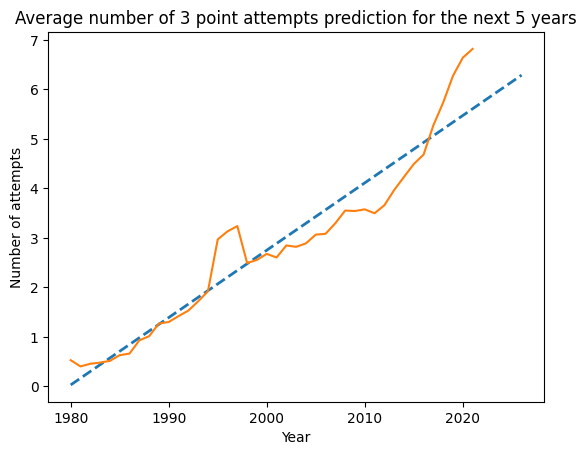

In [ ]:
plt.plot(df_results["Year"], df_results["prediction"], linewidth = 2, linestyle = '--', label = 'LR Fit')
plt.plot(training_yrs, training_y, label = None)
plt.xlabel('Year')
plt.ylabel('Number of attempts')
plt.title("Average number of 3 point attempts prediction for the next 5 years")